# CNN Models

In [1]:
# Required imports:

import datetime
import os 
import shutil
import sys

import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

sys.path.append(os.path.join("..", "code"))
from cnn_dataset import CNNSeqDataset
from cnn_models import GAPTransArchitecture, GAPTransMaxArchitecture
from tif_files import TifFile, TifDir
from utils import convert_datetime, get_y_data, open_y_data, sat_img_filelist_df

pd.set_option("display.max_colwidth", 500)


DIR = os.getcwd()
DATA_DIR = os.path.join(os.path.dirname(DIR), "data")

## Specify Training Parameters

In [2]:
# Which gages to model:
# GAGES = ['11402000', '11318500', '11266500', '11208000', '11202710', '11185500', '11189500']
GAGES = ['11402000']
         
# Location of training data:
TRAIN_DIR = os.path.join(DATA_DIR, "training_data") 
Y_FP = os.path.join(DATA_DIR, "streamgage-full.csv")
Y_COL = "m3"

# Date bounds of different datasets:
date_params = {
    "train": {
        "start": "2010_01_01", 
        "end": "2014_12_31", 
    },
    "val": {
        "start": "2015_01_01", 
        "end": "2015_12_31", 
    },
    "test": {
        "start": "2016_01_01", 
        "end": "2016_12_31", 
    },
}
date_params_dt = dict()
for k, v in date_params.items():
    date_params_dt[k] = dict()
    for k2, v2 in v.items():
        date_params_dt[k][k2] = convert_datetime(v2)

## Specify Model Parameters

In [3]:
N_DAYS_PRECIP = 7
N_DAYS_TEMP = 7
N_DAYS_ET = 8
SWE_DAYS_RELATIVE = range(7, 85, 7)
N_DAYS_Y = 14
USE_MASKS = True

## Create dataset generator

In [4]:
cnn_data = CNNSeqDataset(
    precip_dirs = [TRAIN_DIR],
    temp_dirs = [TRAIN_DIR],
    et_dirs = [TRAIN_DIR],
    swe_dirs = [TRAIN_DIR],
    y_fp = Y_FP,
    y_col = Y_COL,
    n_d_precip = N_DAYS_PRECIP,
    n_d_temp = N_DAYS_TEMP,
    n_d_et = N_DAYS_ET,
    swe_d_rel = SWE_DAYS_RELATIVE,
    n_d_y = N_DAYS_Y,
    min_date = date_params_dt["train"]["start"],
    max_date = date_params_dt["test"]["end"],
    val_start = date_params_dt["val"]["start"],
    test_start = date_params_dt["test"]["start"],
    use_masks=USE_MASKS,
    random_seed = 42,
    shuffle_train = True,
    gages = GAGES,
)

Calculating pixel mean/std from 1 images


100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


In [5]:
print(f"Num training examples = {len(cnn_data.train_pairs)}")

Num training examples = 1742


In [6]:
train_fp_gen = cnn_data.train_filepath_generator()
train_data_gen = cnn_data.train_data_generator()

Test the generators. They should run until `StopIterationError` is encountered when it reaches the number of training examples printed above.

In [7]:
i = 0
while True:
    data = next(train_fp_gen)
    assert isinstance(data, dict)
    i += 1
    count = f"{i}".rjust(6)
    print(f"\rGenerated {count} filepaths", end="")

Generated   1742 filepaths

StopIteration: 

In [8]:
i = 0
while True:
    data = next(train_data_gen)
    assert isinstance(data, dict)
    i += 1
    count = f"{i}".rjust(6)
    print(f"\rGenerated {count} data samples", end="")

Generated   1742 data samples

StopIteration: 

## CNN Model - GAP Transformer

In [7]:
architecture = GAPTransArchitecture()

gap_trans_model = architecture.get_model(
    dem_kernal=(5, 5), dem_strides=(1, 1),
    et_kernal=(4, 4), et_strides=(1, 1),
    temp_kernal=(2, 2), temp_strides=(1, 1),
    precip_kernal=(2, 2), precip_strides=(1, 1),
    swe_kernal=(5, 5), swe_strides=(1, 1),
    n_days_precip=7, n_days_temp=7,
    n_swe=12,
    enc_embed_dim=16, enc_dense_dim=32, enc_num_heads=2,
    dec_embed_dim=16, dec_dense_dim=32, dec_num_heads=2,
    n_y=14, hidden_dim=16, dropout=0.5
)
gap_trans_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dem_inputs (InputLayer)        [(None, 1, None, No  0           []                               
                                ne, 1)]                                                           
                                                                                                  
 temp_inputs (InputLayer)       [(None, 7, None, No  0           []                               
                                ne, 1)]                                                           
                                                                                                  
 precip_inputs (InputLayer)     [(None, 7, None, No  0           []                               
                                ne, 1)]                                                       

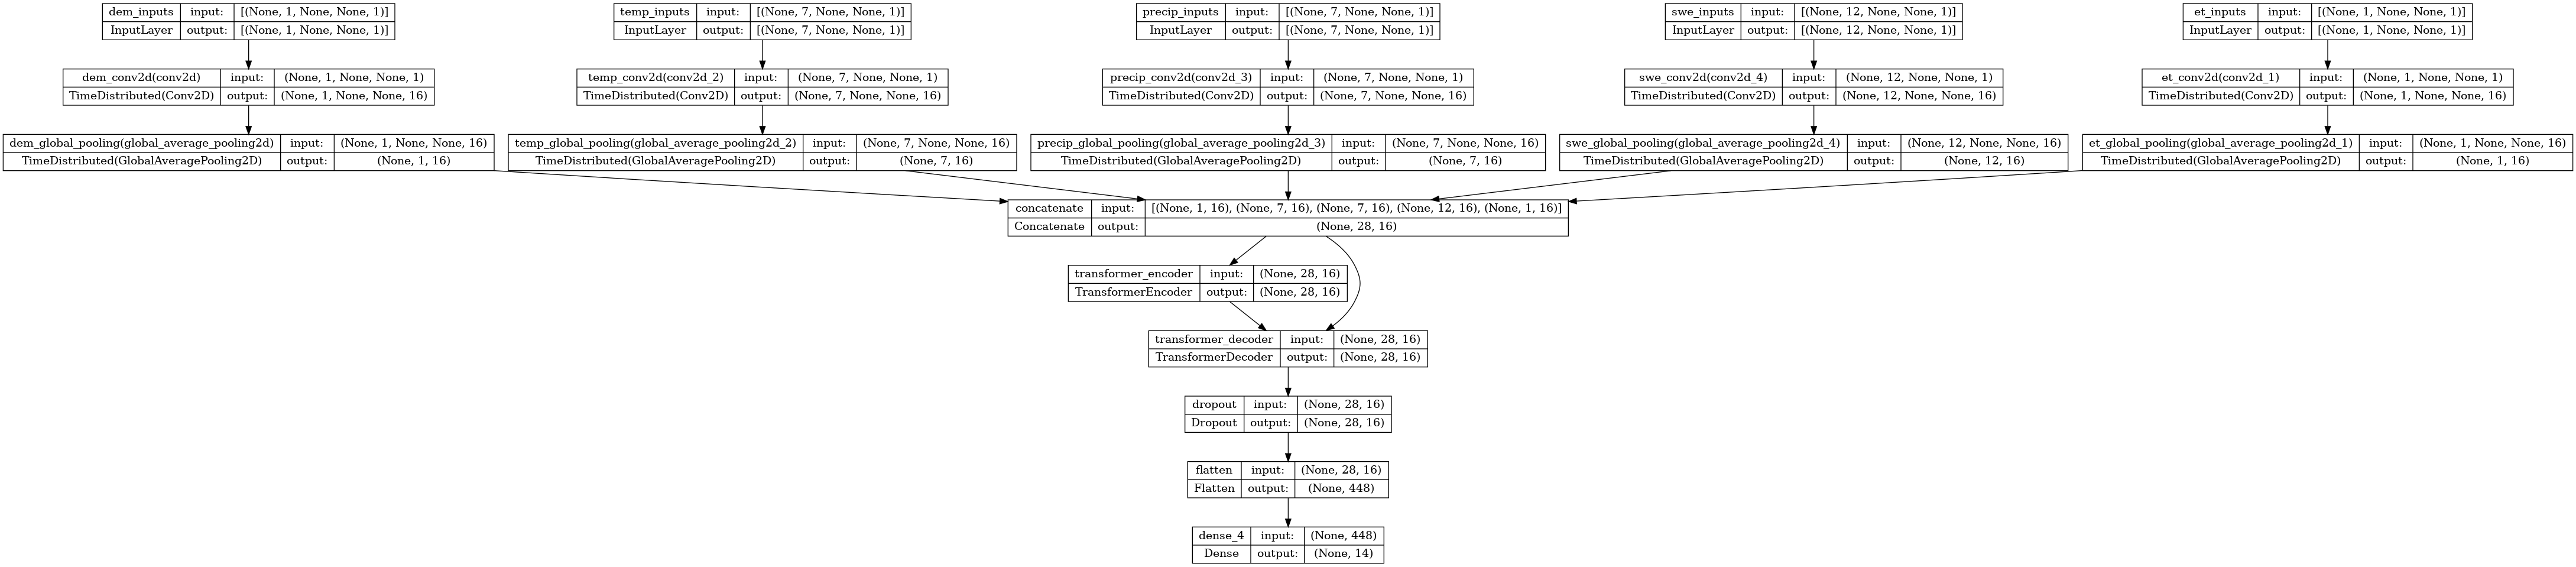

In [9]:
keras.utils.plot_model(gap_trans_model, "gap_trans_model.png", show_shapes=True)

## Train the model

In [10]:
def keras_train_gen(features = ("dem", "temp", "precip", "swe", "et"), debug: bool = False):
    """Construct Keras-compatible generator from the CNNSeqDataset generator."""
    train_data_gen = cnn_data.train_data_generator()
    i = 0
    while True:
        
        # Generate the training sample dict, making the generator infinite:
        try:
            sample = next(train_data_gen)
        except StopIteration:
            # Reset the generator:
            train_data_gen = cnn_data.train_data_generator()
            i = 0
            sample = next(train_data_gen)

        # Print debug info:
        if debug:
            date = sample["debug_data"][0].strftime("%Y_%m_%d")
            gage = sample["debug_data"][1]
            print(f"Sample {i} ({date}, {gage})")
        
        # Yield data in format required by tensorflow:
        X = [sample[f] for f in features]
        X = tuple([np.expand_dims(np.expand_dims(x, -1), 0) for x in X])
        yield X, np.expand_dims(sample["y"], 0)
        i += 1

In [11]:
def keras_val_gen(features = ("dem", "temp", "precip", "swe", "et"), debug: bool = False):
    """Construct Keras-compatible generator from the CNNSeqDataset generator."""
    data_gen = cnn_data.val_data_generator()
    i = 0
    while True:
        
        # Generate the training sample dict, making the generator infinite:
        try:
            sample = next(data_gen)
        except StopIteration:
            # Reset the generator:
            data_gen = cnn_data.val_data_generator()
            i = 0
            sample = next(data_gen)

        # Print debug info:
        if debug:
            date = sample["debug_data"][0].strftime("%Y_%m_%d")
            gage = sample["debug_data"][1]
            print(f"Sample {i} ({date}, {gage})")
        
        # Yield data in format required by tensorflow:
        X = [sample[f] for f in features]
        X = tuple([np.expand_dims(np.expand_dims(x, -1), 0) for x in X])
        yield X, np.expand_dims(sample["y"], 0)
        i += 1

In [12]:
# Create the TF Dataset:
train_data = tf.data.Dataset.from_generator(
    keras_train_gen, 
    output_signature=(
        (  # X-variables:
            tf.TensorSpec(shape=(None, 1, None, None, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 7, None, None, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 7, None, None, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 12, None, None, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 1, None, None, 1), dtype=tf.float32),
        ),
        # y-variable:
        tf.TensorSpec(shape=(1, 14), dtype=tf.float32)
    )
)

val_data = tf.data.Dataset.from_generator(
    keras_val_gen, 
    output_signature=(
        (  # X-variables:
            tf.TensorSpec(shape=(None, 1, None, None, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 7, None, None, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 7, None, None, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 12, None, None, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 1, None, None, 1), dtype=tf.float32),
        ),
        # y-variable:
        tf.TensorSpec(shape=(1, 14), dtype=tf.float32)
    )
)


# Note that because the data generator runs infinitely you have to manually
# specify the number of training examples per epoch:
STEPS_PER_EPOCH = len(cnn_data.train_pairs)
VAL_STEPS = len(cnn_data.val_pairs)

# Train the model:
opt = keras.optimizers.Adam(learning_rate=0.0001)
gap_trans_model.compile(optimizer=opt, loss="mean_squared_error")
gap_trans_model.fit(train_data, epochs=1, batch_size=1, steps_per_epoch=STEPS_PER_EPOCH, 
                    validation_data=val_data, validation_steps=VAL_STEPS, validation_batch_size=1, validation_freq=1)

## CNN Model - GAP Transformer + Max Pooling Layers for Image Resizing

In [13]:
architecture = GAPTransMaxArchitecture()

gap_trans_max_model = architecture.get_model(
    kernal=(2, 2), strides=(1, 1),
    n_days_precip=7, n_days_temp=7,
    n_swe=12,
    enc_embed_dim=16, enc_dense_dim=32, enc_num_heads=2,
    dec_embed_dim=16, dec_dense_dim=32, dec_num_heads=2,
    n_y=14, hidden_dim=16, dropout=0.5, cnn_activation="relu"
)
gap_trans_max_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 DEM_inputs (InputLayer)        [(None, 1, None, No  0           []                               
                                ne, 1)]                                                           
                                                                                                  
 DEM_conv2d_0 (TimeDistributed)  (None, 1, None, Non  26         ['DEM_inputs[0][0]']             
                                e, 1)                                                             
                                                                                                  
 DEM_max_pooling_0 (TimeDistrib  (None, 1, None, Non  0          ['DEM_conv2d_0[0][0]']           
 uted)                          e, 1)                                                       

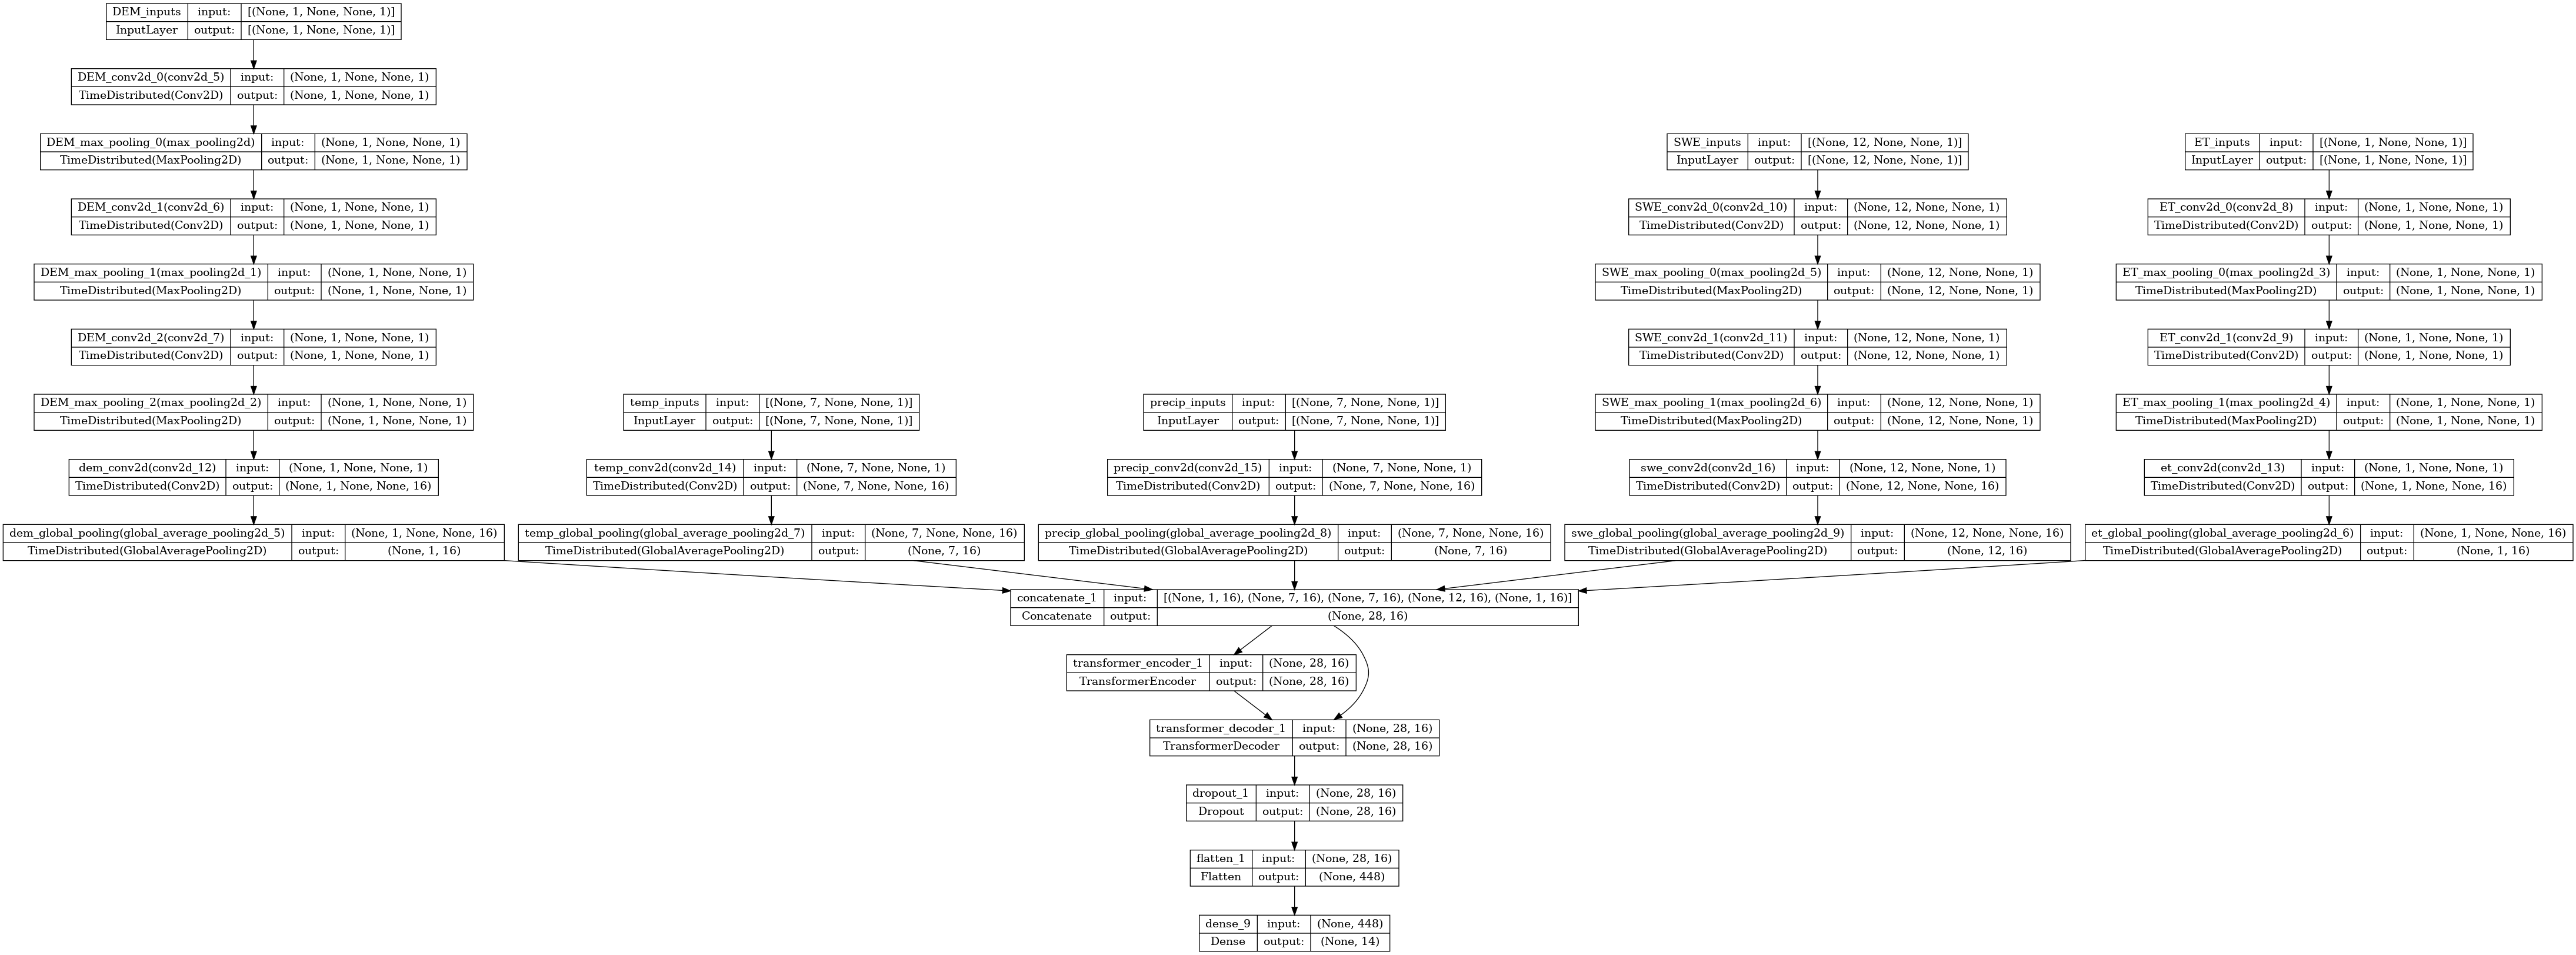

In [14]:
keras.utils.plot_model(gap_trans_max_model, "gap_trans_max_model.png", show_shapes=True)

In [18]:
# Create the TF Dataset:
train_data = tf.data.Dataset.from_generator(
    keras_train_gen, 
    output_signature=(
        (  # X-variables:
            tf.TensorSpec(shape=(None, 1, None, None, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 7, None, None, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 7, None, None, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 12, None, None, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 1, None, None, 1), dtype=tf.float32),
        ),
        # y-variable:
        tf.TensorSpec(shape=(1, 14), dtype=tf.float32)
    )
)

val_data = tf.data.Dataset.from_generator(
    keras_val_gen, 
    output_signature=(
        (  # X-variables:
            tf.TensorSpec(shape=(None, 1, None, None, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 7, None, None, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 7, None, None, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 12, None, None, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 1, None, None, 1), dtype=tf.float32),
        ),
        # y-variable:
        tf.TensorSpec(shape=(1, 14), dtype=tf.float32)
    )
)


# Note that because the data generator runs infinitely you have to manually
# specify the number of training examples per epoch:
STEPS_PER_EPOCH = len(cnn_data.train_pairs)
VAL_STEPS = len(cnn_data.val_pairs)

# Train the model:
opt = keras.optimizers.Adam(learning_rate=0.0001)
gap_trans_max_model.compile(optimizer=opt, loss="mean_squared_error")
gap_trans_max_model.fit(train_data, epochs=1, batch_size=1, steps_per_epoch=STEPS_PER_EPOCH, 
                        validation_data=val_data, validation_steps=VAL_STEPS, validation_batch_size=1, validation_freq=1)

1742/1742 [==============================] - 177s 98ms/step - loss: 82.4685 - val_loss: 33.9666
